https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Crashes/h9gi-nx95?fbclid=IwAR3WB8cL1Qk7icQgbjaj8rw3iGGjo8M4wRIiEAb3zZC8anTow9uV4IvxTcU
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Vehicles/bm4k-52h4?fbclid=IwAR17Ba6CEepQQTKNt5qIB-p2QQmSWS8HrTei1kygpXaWkKQeutg3IPGVjuo
https://data.cityofnewyork.us/Public-Safety/Motor-Vehicle-Collisions-Person/f55k-p6yu?fbclid=IwAR1k9QCQYOXIHXw061OGsCp0kmBlFOrSl310kjpSIpp2CYdgVb6odkgNm20

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import shapefile as shp
import urllib, gdal, subprocess
import json
import requests
import folium
import datetime
import warnings
import random
warnings.filterwarnings("ignore")

sns.set(style='darkgrid', palette='muted', color_codes=True)
#sns.mpl.rc('figure', figsize=(10,6))
# Set a plot style for nice plots.

# Magic command useful jupyter notebook
%matplotlib inline



#Set font size
plt.rcParams.update({'font.size':16})

In [3]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [4]:
%%time
# filename = "Motor_Vehicle_Collisions_-_Crashes.csv"
# filename = "Motor_Vehicle_Collisions_-_Person.csv"
filename = 'people_clean.csv'
# filename = "crash_clean.csv"
p = 1 # 1% of the lines
# keep the header, then take only 1% of lines
# if random from [0,1] interval is greater than 0.01 the row will be skipped
df = pd.read_csv(
         filename,
         header=0, 
         skiprows=lambda i: i>0 and random.random() > p)

# df2 = pd.read_csv(
#          filename2,
#          header=0, 
#          skiprows=lambda i: i>0 and random.random() > p)

Wall time: 21 s


In [5]:
df.shape

(3908459, 12)

In [6]:
df.head()

,Unnamed: 0,UNIQUE_ID,COLLISION_ID,CRASH_DATE,CRASH_TIME,PERSON_ID,PERSON_TYPE,PERSON_INJURY,VEHICLE_ID,PERSON_AGE,PED_ROLE,PERSON_SEX
0,0,10252788,4230640,10/25/2019,17:42,0278267c-0b21-470f-8a54-da71b7361448,Occupant,Unspecified,19142923.0,0.0,Passenger,F
1,1,10253512,4230733,10/10/2019,19:45,81161123-516c-438d-8f29-a107d2783d85,Occupant,Unspecified,19143291.0,Unspecified,Registrant,U
2,2,10250662,4230235,10/26/2019,10:40,b5da9aa6-3230-4203-bbde-3b6f9248ac31,Occupant,Injured,19141868.0,11.0,Passenger,F
3,3,10252894,4231115,10/26/2019,18:45,4ed210b6-678c-4fe3-ae8c-3ecd30eae7aa,Pedestrian,Injured,Unspecified,30.0,Pedestrian,M
4,4,6650180,3565527,11/21/2016,13:05,2782525,Occupant,Unspecified,Unspecified,Unspecified,Notified Person,U


In [11]:
df.columns

Index(['Unnamed: 0', 'UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME',
       'PERSON_ID', 'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE',
       'PED_ROLE', 'PERSON_SEX'],
      dtype='object')

In [14]:
df.groupby('PED_ROLE').size()

PED_ROLE
Driver             1427569
In-Line Skater         203
Notified Person       4380
Other                  988
Owner                14451
Passenger           566287
Pedestrian           48961
Policy Holder         2415
Registrant         1599438
Unspecified         194895
Witness              48872
dtype: int64

In [10]:
df['PERSON_SEX'].unique()

array(['F', 'U', 'M'], dtype=object)

In [9]:
# df = df.loc[(df.LONGITUDE >-77) & (df.LONGITUDE < -69) & (df.LATITUDE <43) & (df.LATITUDE > 38)]
df = df.loc[(df['PERSON_AGE']>0) & (df['PERSON_AGE'] <100 )]

In [11]:
df['CRASH_TIME'] = pd.to_datetime(df['CRASH_TIME'])
df['CRASH_DATE'] = pd.to_datetime(df['CRASH_DATE'])

In [13]:
df.groupby('PERSON_INJURY').size()

PERSON_INJURY
Injured         420614
Killed            1876
Unspecified    2642222
dtype: int64

In [62]:
# X = df[['CRASH TIME','NUMBER OF PERSONS INJURED']]
X = df[['PERSON_INJURY','CRASH_DATE','CRASH_TIME','PERSON_TYPE','PERSON_AGE']]
print('Shape before drop {}'.format(X.shape))
X = X.dropna()
print('Shape after drop {}'.format(X.shape))

Shape before drop (3064712, 5)
Shape after drop (3064712, 5)


In [63]:
X['CRASH_TIME'] = df['CRASH_TIME'].dt.hour
X['CRASH_DATE'] = df['CRASH_DATE'].dt.dayofweek

In [64]:
X = X.drop(X[X['PERSON_INJURY']=='Killed'].sample(frac=1).index)

In [65]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()
X['PERSON_INJURY'] = labelencoder.fit_transform(X['PERSON_INJURY'])
X['PERSON_TYPE'] = labelencoder.fit_transform(X['PERSON_TYPE'])
# X = X.drop(X[X['PERSON_INJURY']==1].sample(frac=1).index)

In [66]:
# X['PERSON_INJURY'] = X['PERSON_INJURY'].apply(lambda x: 1 if x==2 else x)

In [67]:
X

,PERSON_INJURY,CRASH_DATE,CRASH_TIME,PERSON_TYPE,PERSON_AGE
2,0,5,10,1,11.0
3,0,5,18,2,30.0
5,1,4,2,1,29.0
6,1,2,19,1,24.0
7,1,5,17,1,29.0
...,...,...,...,...,...
3908454,1,0,18,1,39.0
3908455,1,0,17,1,44.0
3908456,1,0,18,1,37.0
3908457,1,0,20,1,58.0


In [68]:
X.groupby('PERSON_INJURY').size()

PERSON_INJURY
0     420614
1    2642222
dtype: int64

In [69]:
mi = min(X.groupby('PERSON_INJURY').size())
ma = max(X.groupby('PERSON_INJURY').size())
X = X.drop(X[X['PERSON_INJURY']==1].sample(frac=(1-(mi/ma))).index)

In [70]:
X.groupby(['PERSON_INJURY']).size()

PERSON_INJURY
0    420614
1    420614
dtype: int64

In [71]:
y = X['PERSON_INJURY']
X = X[['CRASH_DATE','CRASH_TIME','PERSON_TYPE','PERSON_AGE']]

In [72]:
X = pd.get_dummies(X,columns=['PERSON_TYPE','CRASH_DATE'])
X

,CRASH_TIME,PERSON_AGE,PERSON_TYPE_0,PERSON_TYPE_1,PERSON_TYPE_2,CRASH_DATE_0,CRASH_DATE_1,CRASH_DATE_2,CRASH_DATE_3,CRASH_DATE_4,CRASH_DATE_5,CRASH_DATE_6
2,10,11.0,0,1,0,0,0,0,0,0,1,0
3,18,30.0,0,0,1,0,0,0,0,0,1,0
6,19,24.0,0,1,0,0,0,1,0,0,0,0
11,15,30.0,0,1,0,0,0,0,0,0,1,0
12,8,23.0,0,1,0,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
3908436,19,32.0,0,1,0,1,0,0,0,0,0,0
3908439,6,56.0,0,1,0,1,0,0,0,0,0,0
3908447,11,32.0,0,1,0,1,0,0,0,0,0,0
3908455,17,44.0,0,1,0,1,0,0,0,0,0,0


In [73]:
header = X.columns.values.tolist()

In [74]:
X = X.values
y = y.values

X_mean = X.mean(axis=0)
X_std = X.std(axis=0)
X = (X - X_mean) / X_std

In [75]:
from sklearn.decomposition import PCA

In [76]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [77]:
# pca = PCA(n_components=10)
# pca.fit(X_train)
# X_train = pca.transform(X_train)
# pca.fit(X_test)
# X_test = pca.transform(X_test)
# print(pca.explained_variance_ratio_)

In [78]:
clf = LogisticRegression()
clf.fit(X_train,y_train)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [79]:
prediction = clf.predict(X_test)

In [80]:
accuracy_score(y_test,prediction)

0.6444961564231321

Feature 0: CRASH_TIME, SCORE 0.02
Feature 1: PERSON_AGE, SCORE 0.24
Feature 2: PERSON_TYPE_0, SCORE -0.28
Feature 3: PERSON_TYPE_1, SCORE 0.86
Feature 4: PERSON_TYPE_2, SCORE -0.81
Feature 5: CRASH_DATE_0, SCORE 0.00
Feature 6: CRASH_DATE_1, SCORE 0.01
Feature 7: CRASH_DATE_2, SCORE 0.01
Feature 8: CRASH_DATE_3, SCORE 0.02
Feature 9: CRASH_DATE_4, SCORE 0.02
Feature 10: CRASH_DATE_5, SCORE -0.02
Feature 11: CRASH_DATE_6, SCORE -0.05


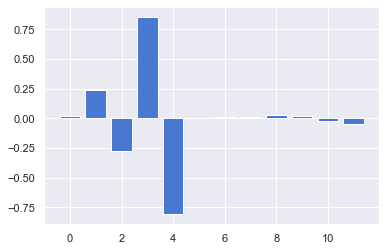

In [81]:
importance = clf.coef_[0]
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature {}: {}, SCORE {:.2f}'.format(i,header[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

In [82]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification

In [83]:
clf = RandomForestClassifier(n_estimators = 50)
clf.fit(X_train,y_train)
prediction = clf.predict(X_test)
accuracy_score(y_test,prediction)

0.6452958509542301

In [84]:
(prediction==1).sum()

189083

In [85]:
(prediction==0).sum()

88523

Feature 0: CRASH_TIME, SCORE 0.11
Feature 1: PERSON_AGE, SCORE 0.21
Feature 2: PERSON_TYPE_0, SCORE 0.09
Feature 3: PERSON_TYPE_1, SCORE 0.36
Feature 4: PERSON_TYPE_2, SCORE 0.22
Feature 5: CRASH_DATE_0, SCORE 0.00
Feature 6: CRASH_DATE_1, SCORE 0.00
Feature 7: CRASH_DATE_2, SCORE 0.00
Feature 8: CRASH_DATE_3, SCORE 0.00
Feature 9: CRASH_DATE_4, SCORE 0.00
Feature 10: CRASH_DATE_5, SCORE 0.00
Feature 11: CRASH_DATE_6, SCORE 0.00


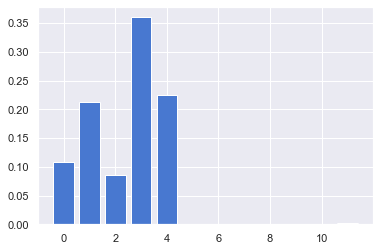

In [86]:
importance = clf.feature_importances_
# summarize feature importance
for i,v in enumerate(importance):
    print('Feature {}: {}, SCORE {:.2f}'.format(i,header[i],v))
# plot feature importance
plt.bar([x for x in range(len(importance))], importance)
plt.show()

## K-nearest neighbour

TypeError: '>' not supported between instances of 'str' and 'int'